In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## _Exploratory Analysis_

### _Import Libraries_

In [5]:
!pip install catboost

     |████████████████████████████████| 64.8MB 60kB/s 


In [0]:
# import libraries

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
#%matplotlib inline 
import os
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [0]:
#read data

df_train = pd.read_csv('/content/drive/My Drive/mobility/train_Wc8LBpr.csv')
df_test = pd.read_csv('/content/drive/My Drive/mobility/test_VsU9xXK.csv')
sub = pd.read_csv('/content/drive/My Drive/mobility/sample_submission_NoPBkjr.csv')

JanataHack: Mobility Analytics
Welcome to Sigma Cab Private Limited - a cab aggregator service. Their customers can download their app on smartphones and book a cab from any where in the cities they operate in. They, in turn search for cabs from various service providers and provide the best option to their client across available options. They have been in operation for little less than a year now. During this period, they have captured surge_pricing_type from the service providers.

You have been hired by Sigma Cabs as a Data Scientist and have been asked to build a predictive model, which could help them in predicting the surge_pricing_type pro-actively. This would in turn help them in matching the right cabs with the right customers quickly and efficiently.

Approach
No feature Engineering done.
Created separate group for null values in categorical varaibles
Updated the null values for continous varaibles with mean/medain
Used CAT boost with 5 fold CV

leader board one **code** 

In [0]:
#filling na values and 
df_train.Type_of_Cab.fillna("F",inplace=True)
df_test.Type_of_Cab.fillna("F",inplace=True)
df_train.Life_Style_Index.fillna(df_train.Life_Style_Index.mean(),inplace=True)
df_test.Life_Style_Index.fillna(df_test.Life_Style_Index.mean(),inplace=True)

df_train.Customer_Since_Months.fillna(99,inplace=True)
df_test.Customer_Since_Months.fillna(99,inplace=True)
df_train.Customer_Since_Months = df_train.Customer_Since_Months.astype(int)
df_test.Customer_Since_Months = df_test.Customer_Since_Months.astype(int)


df_train.Var1.fillna(df_train.Var1.median(),inplace=True)
df_test.Var1.fillna(df_test.Var1.median(),inplace=True)
df_train.Confidence_Life_Style_Index.fillna('D',inplace=True)
df_test.Confidence_Life_Style_Index.fillna('D',inplace=True)


In [9]:

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131662 entries, 0 to 131661
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Trip_ID                      131662 non-null  object 
 1   Trip_Distance                131662 non-null  float64
 2   Type_of_Cab                  131662 non-null  object 
 3   Customer_Since_Months        131662 non-null  int64  
 4   Life_Style_Index             131662 non-null  float64
 5   Confidence_Life_Style_Index  131662 non-null  object 
 6   Destination_Type             131662 non-null  object 
 7   Customer_Rating              131662 non-null  float64
 8   Cancellation_Last_1Month     131662 non-null  int64  
 9   Var1                         131662 non-null  float64
 10  Var2                         131662 non-null  int64  
 11  Var3                         131662 non-null  int64  
 12  Gender                       131662 non-null  object 
 13 

In [0]:
from sklearn.model_selection import StratifiedKFold,KFold
# Set up folds
K = 5
kf = KFold(n_splits = K, random_state = 7, shuffle = True)
skf = StratifiedKFold(n_splits = K, random_state = 7, shuffle = True)

In [0]:
MAX_ROUNDS = 1000
OPTIMIZE_ROUNDS = False
#LEARNING_RATE = 0.1

In [12]:
from sklearn.metrics import accuracy_score
X = df_train.drop(columns=['Trip_ID','Surge_Pricing_Type'],axis=1)
y = df_train['Surge_Pricing_Type']
X_test = df_test.drop(columns='Trip_ID',axis=1)
y_valid_pred = 0*y
y_test_pred = 0
accuracy = 0
result={}
#specifying categorical variables indexes
cat_columns = ['Type_of_Cab','Confidence_Life_Style_Index','Destination_Type','Gender','Customer_Since_Months']
#fitting catboost classifier model
j=1
model = CatBoostClassifier(n_estimators=MAX_ROUNDS,verbose=False)
for i, (train_index, test_index) in enumerate(kf.split(df_train)):

#for train_index, test_index in skf.split(X, y):  
    # Create data for this fold
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    X_train, X_valid = X.iloc[train_index,:], X.iloc[test_index,:]
    print( "\nFold ", j)
    #print( "\nFold ", i)
    
    # Run model for this fold
    if OPTIMIZE_ROUNDS:
        fit_model = model.fit( X_train, y_train, 
                               eval_set=[X_valid, y_valid],cat_features=cat_columns,
                               use_best_model=True
                             )
        print( "  N trees = ", model.tree_count_ )
    else:
        fit_model = model.fit( X_train, y_train,cat_features=cat_columns )
        
    # Generate validation predictions for this fold
    pred = fit_model.predict(X_valid)
    y_valid_pred.iloc[test_index] = pred.reshape(-1)
    print(accuracy_score(y_valid,pred))
    accuracy+=accuracy_score(y_valid,pred)
    # Accumulate test set predictions
    y_test_pred += fit_model.predict(X_test)
    result[j]=fit_model.predict(X_test)
    j+=1
results = y_test_pred / K  # Average test set predictions
print(accuracy/5)



Fold  1
0.7068697072114837

Fold  2
0.707857061481791

Fold  3
0.7057952301382349

Fold  4
0.7008962479112867

Fold  5
0.7046559319459214
0.7052148357377435


In [0]:
d = pd.DataFrame()
for i in range(1, 6):
    d = pd.concat([d,pd.DataFrame(result[i])],axis=1)
d.columns=['1','2','3','4','5']
#d.to_csv("d.csv",index=False)

In [0]:
re = d.mode(axis=1)[0]

In [0]:
sub.Surge_Pricing_Type = re
sub.to_csv('cb_k.csv',index = False)

In [16]:
sub

,Trip_ID,Surge_Pricing_Type
0,T0005689459,1.0
1,T0005689462,2.0
2,T0005689463,2.0
3,T0005689466,2.0
4,T0005689468,2.0
...,...,...
87390,T0005908503,2.0
87391,T0005908504,2.0
87392,T0005908505,1.0
87393,T0005908511,2.0


My own **code**

#### Compare the datasets for the number of values that are missing in training and testing dataset

In [0]:
cab_data1 = cab_data.copy()
cab_data1 = cab_data1.drop('Surge_Pricing_Type', axis = 1)
cab_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131662 entries, 0 to 131661
Data columns (total 13 columns):
Trip_ID                        131662 non-null object
Trip_Distance                  131662 non-null float64
Type_of_Cab                    111452 non-null object
Customer_Since_Months          125742 non-null float64
Life_Style_Index               111469 non-null float64
Confidence_Life_Style_Index    111469 non-null object
Destination_Type               131662 non-null object
Customer_Rating                131662 non-null float64
Cancellation_Last_1Month       131662 non-null int64
Var1                           60632 non-null float64
Var2                           131662 non-null int64
Var3                           131662 non-null int64
Gender                         131662 non-null object
dtypes: float64(5), int64(3), object(5)
memory usage: 13.1+ MB


In [0]:
### The function compare_train_test compares the training and testing dataset to check if the same set of 
### categorical values are present in both the dataframes.
def compare_train_test(train_data, test_data):
    train_levels = train_data.apply(lambda x: set(x.unique()),axis=0)
    test_levels = test_data.apply(lambda x: set(x.unique()),axis=0)
    extra = []
    missing = []
    for x1,x2 in zip(train_levels, test_levels):
        missing.append(x1-x2)
        extra.append(x2-x1)
    
    return pd.DataFrame({"Train Data Type":train_data.dtypes, "Test Data Type":test_data.dtypes,
                         "Train #Levels":train_data.apply(lambda x: x.unique().shape[0],axis=0),"Test #Levels":test_data.apply(lambda x: x.unique().shape[0],axis=0),
                         "Test Missing":missing, "Test Extra":extra})
compare_train_test(cab_data1, valid_data)

,Train Data Type,Test Data Type,Train #Levels,Test #Levels,Test Missing,Test Extra
Trip_ID,object,object,131662,87395,"{T0005787686, T0005879504, T0005781197, T00057...","{T0005867185, T0005903661, T0005865886, T00057..."
Trip_Distance,float64,float64,10326,9942,"{1.62, 2.75, 2.5, 2.0, 2.83, 4.52, 5.52, 7.52,...","{1.75, 2.11, 2.21, 1.96, 1.69, 102.12, 103.37,..."
Type_of_Cab,object,object,6,6,{},{}
Customer_Since_Months,float64,float64,12,12,{nan},{nan}
Life_Style_Index,float64,float64,55979,44858,"{nan, 1.9063400000000001, 2.52337, 2.03125, 3....","{nan, 1.8994900000000001, 2.72654, 3.53904, 2...."
Confidence_Life_Style_Index,object,object,4,4,{},{}
Destination_Type,object,object,14,14,{},{}
Customer_Rating,float64,float64,3931,3857,"{0.0625, 0.09375, 0.5625, 0.34375, 4.98875, 0....","{0.12, 0.1175, 0.26125, 0.48125, 0.1375, 0.306..."
Cancellation_Last_1Month,int64,int64,9,9,{},{}
Var1,float64,float64,123,106,"{nan, 129.0, 128.0, 132.0, 133.0, 135.0, 136.0...","{nan, 137.0, 140.0, 178.0, 151.0, 152.0, 123.0..."


### _Understand the dataset_

In [0]:
# What are the names of the columns?
print(list(cab_data.columns))

['Trip_ID', 'Trip_Distance', 'Type_of_Cab', 'Customer_Since_Months', 'Life_Style_Index', 'Confidence_Life_Style_Index', 'Destination_Type', 'Customer_Rating', 'Cancellation_Last_1Month', 'Var1', 'Var2', 'Var3', 'Gender', 'Surge_Pricing_Type']


In [0]:
# What are the data types?
cab_data.dtypes

Trip_ID                         object
Trip_Distance                  float64
Type_of_Cab                     object
Customer_Since_Months          float64
Life_Style_Index               float64
Confidence_Life_Style_Index     object
Destination_Type                object
Customer_Rating                float64
Cancellation_Last_1Month         int64
Var1                           float64
Var2                             int64
Var3                             int64
Gender                          object
Surge_Pricing_Type               int64
dtype: object

In [0]:
# What is the distribution of numerical columns?
cab_data.describe()

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Surge_Pricing_Type
count,131662.000000,125742.000000,111469.000000,131662.000000,131662.000000,60632.000000,131662.000000,131662.000000,131662.000000
mean,44.200909,6.016661,2.802064,2.849458,0.782838,64.202698,51.202800,75.099019,2.155747
std,25.522882,3.626887,0.225796,0.980675,1.037559,21.820447,4.986142,11.578278,0.738164
min,0.310000,0.000000,1.596380,0.001250,0.000000,30.000000,40.000000,52.000000,1.000000
25%,24.580000,3.000000,2.654730,2.152500,0.000000,46.000000,48.000000,67.000000,2.000000
50%,38.200000,6.000000,2.798050,2.895000,0.000000,61.000000,50.000000,74.000000,2.000000
75%,60.730000,10.000000,2.946780,3.582500,1.000000,80.000000,54.000000,82.000000,3.000000
max,109.230000,10.000000,4.875110,5.000000,8.000000,210.000000,124.000000,206.000000,3.000000


In [0]:
# what is the distribution of numerical columns in test data ?
valid_data.describe()

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3
count,87395.000000,83429.000000,74068.000000,87395.000000,87395.000000,40606.000000,87395.000000,87395.000000
mean,44.095174,5.990051,2.803392,2.847389,0.783031,63.936610,51.162160,75.015699
std,25.483993,3.626861,0.227113,0.981744,1.034266,21.636247,4.956831,11.582761
min,1.550000,0.000000,1.317850,0.001250,0.000000,30.000000,41.000000,52.000000
25%,24.540000,3.000000,2.654518,2.152500,0.000000,45.000000,48.000000,67.000000
50%,38.060000,6.000000,2.798630,2.895000,0.000000,61.000000,50.000000,73.000000
75%,60.690000,10.000000,2.949053,3.580000,1.000000,79.000000,54.000000,82.000000
max,109.230000,10.000000,4.871920,5.000000,8.000000,178.000000,116.000000,169.000000


In [0]:
# What about categorical variable levels count?
cab_data.describe(include=['object'])

,Trip_ID,Type_of_Cab,Confidence_Life_Style_Index,Destination_Type,Gender
count,131662,111452,111469,131662,131662
unique,131662,5,3,14,2
top,T0005887046,B,B,A,Male
freq,1,31136,40355,77597,93900


In [0]:
# What about categorical variable levels count in test data?
valid_data.describe(include=['object'])

,Trip_ID,Type_of_Cab,Confidence_Life_Style_Index,Destination_Type,Gender
count,87395,74237,74068,87395,87395
unique,87395,5,3,14,2
top,T0005839346,B,B,A,Male
freq,1,20449,26910,51413,62228


In [0]:
cab_data = cab_data.drop('Trip_ID', axis = 1)
valid_data = valid_data.drop('Trip_ID', axis = 1)

In [0]:
cab_data.columns

Index(['Trip_Distance', 'Type_of_Cab', 'Customer_Since_Months',
       'Life_Style_Index', 'Confidence_Life_Style_Index', 'Destination_Type',
       'Customer_Rating', 'Cancellation_Last_1Month', 'Var1', 'Var2', 'Var3',
       'Gender', 'Surge_Pricing_Type'],
      dtype='object')

In [0]:
#### Adding code using the categorical and numerical Columns
num_cols = ['Trip_Distance', 'Customer_Since_Months',
       'Life_Style_Index', 'Customer_Rating', 'Cancellation_Last_1Month', 'Var1', 'Var2', 'Var3']
       
cat_cols = cab_data.columns.difference(num_cols).tolist()

print("Numeric Columns ->", num_cols)
print("Categorical Columns ->", cat_cols)

Numeric Columns -> ['Trip_Distance', 'Customer_Since_Months', 'Life_Style_Index', 'Customer_Rating', 'Cancellation_Last_1Month', 'Var1', 'Var2', 'Var3']
Categorical Columns -> ['Confidence_Life_Style_Index', 'Destination_Type', 'Gender', 'Surge_Pricing_Type', 'Type_of_Cab']


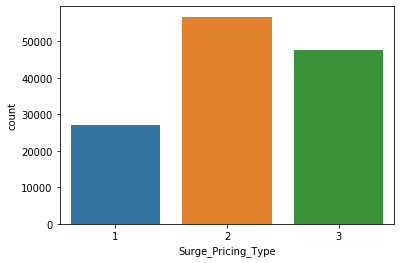

In [0]:
# Checking Target Distribution
sns.countplot(x = 'Surge_Pricing_Type', data = cab_data)


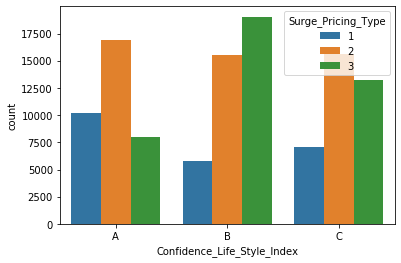

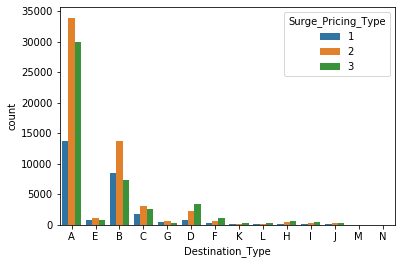

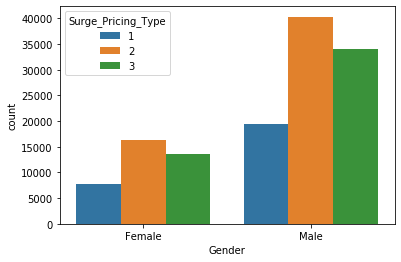

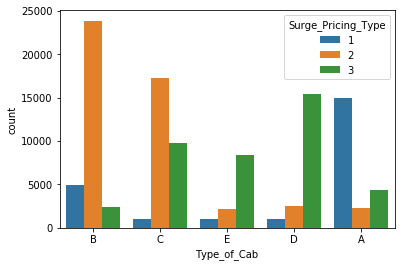

In [0]:
# Checking other columns distribution based on target column
for col in cat_cols:
    if col != 'Surge_Pricing_Type':
        sns.countplot(x = col, hue= 'Surge_Pricing_Type', data = cab_data)
        plt.show()


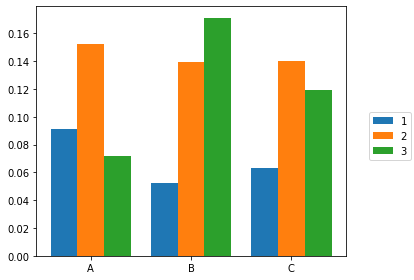

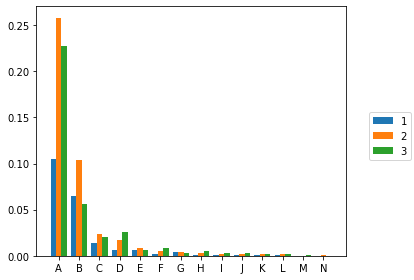

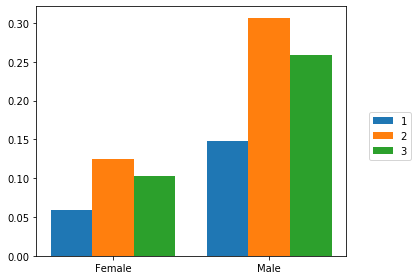

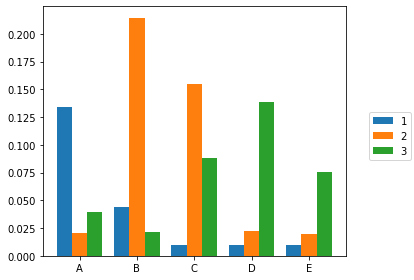

In [0]:
import dexplot as dxp
for col in cat_cols:
    if col != 'Surge_Pricing_Type':
        dxp.aggplot(agg = col, hue= 'Surge_Pricing_Type', data = cab_data, normalize = "all", xlabel = col, orient='v', figsize=(5,4))
        plt.show()
#dxp.aggplot(agg='occupation', data=df, hue='income')

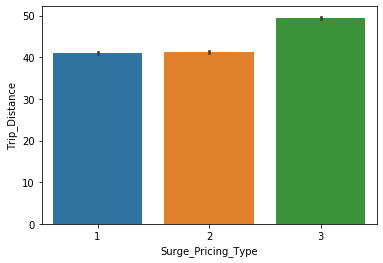

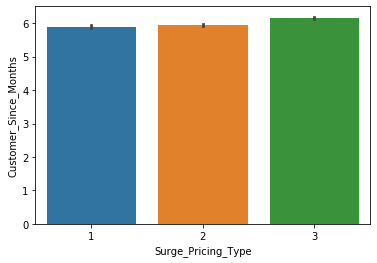

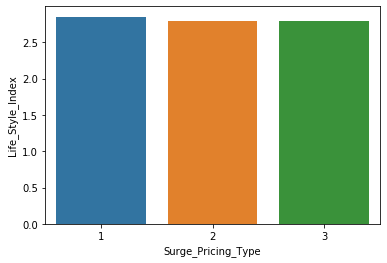

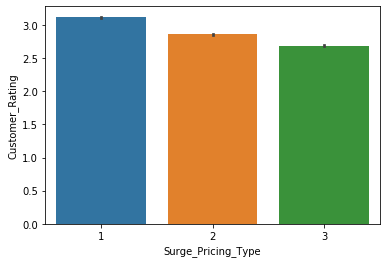

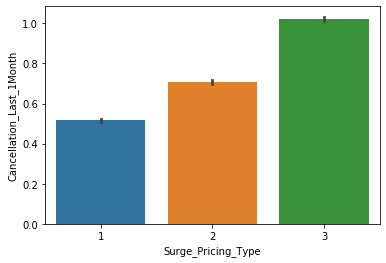

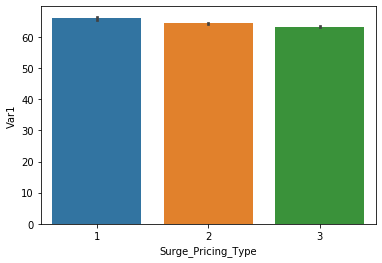

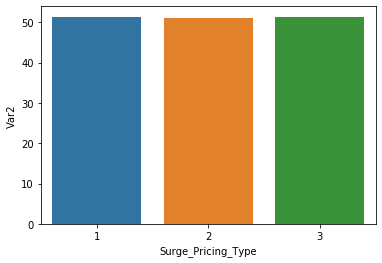

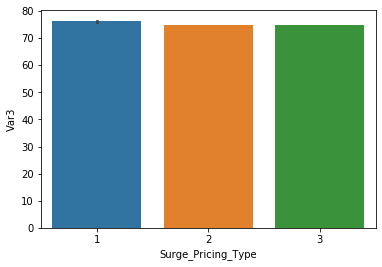

In [0]:
# Check distribution of age
%matplotlib inline
for col in num_cols:
    sns.barplot(y = col, x = 'Surge_Pricing_Type', data = cab_data)
    plt.show()

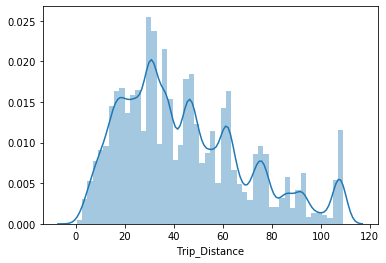

ValueError: Cannot convert non-finite values (NA or inf) to integer

In [0]:
#cab_data[~df['x'].isnull()]df[['x']].astype(int)


for col in cab_data[num_cols]:
    cab_data[~cab_data[col].isnull()],cab_data[[col]].astype(int)
    #cab_data.loc[cab_data[col].isnull(), col].astype(int)
    sns.distplot(cab_data[col])
    plt.show()
   




=============> Trip_Distance <=============



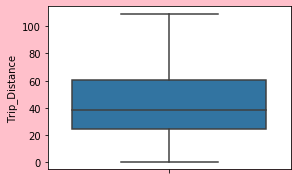





=============> Customer_Since_Months <=============



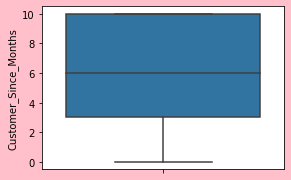





=============> Life_Style_Index <=============



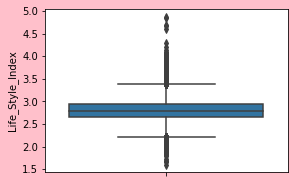





=============> Customer_Rating <=============



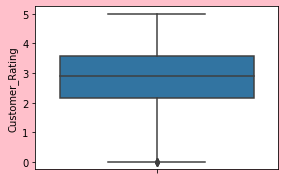





=============> Cancellation_Last_1Month <=============



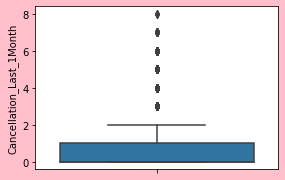





=============> Var1 <=============



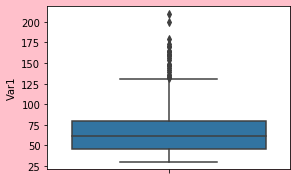





=============> Var2 <=============



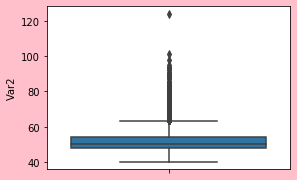





=============> Var3 <=============



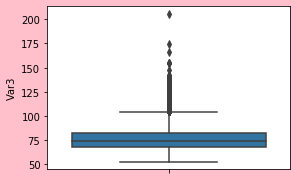

In [0]:
#checking for boxplots for num cols
for col in num_cols:
    print("\n\n\n=============>",col,"<=============\n")
    plt.figure(figsize=(20,3),facecolor='pink')
    plt.subplot(1,4,1)
    sns.boxplot(y=col, data = cab_data)
    plt.show()        
    plt.show()
    print("\n==============================================")


In [0]:
#correlation
corr = cab_data.corr()
print(corr)
corr.style.background_gradient(cmap='coolwarm')


                          Trip_Distance  Customer_Since_Months  \
Trip_Distance                  1.000000               0.116812   
Customer_Since_Months          0.116812               1.000000   
Life_Style_Index               0.509482               0.135114   
Customer_Rating               -0.054654              -0.050349   
Cancellation_Last_1Month      -0.007686              -0.006325   
Var1                          -0.045468              -0.009856   
Var2                           0.200456               0.042637   
Var3                           0.231706               0.113403   
Surge_Pricing_Type             0.135928               0.027827   

                          Life_Style_Index  Customer_Rating  \
Trip_Distance                     0.509482        -0.054654   
Customer_Since_Months             0.135114        -0.050349   
Life_Style_Index                  1.000000         0.205824   
Customer_Rating                   0.205824         1.000000   
Cancellation_Last_1Month

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Surge_Pricing_Type
Trip_Distance,1,0.116812,0.509482,-0.0546542,-0.0076865,-0.0454677,0.200456,0.231706,0.135928
Customer_Since_Months,0.116812,1,0.135114,-0.0503487,-0.00632461,-0.00985628,0.0426373,0.113403,0.0278272
Life_Style_Index,0.509482,0.135114,1,0.205824,0.0740229,-0.0913072,0.234754,0.329312,-0.0801077
Customer_Rating,-0.0546542,-0.0503487,0.205824,1,0.00359534,-0.0109678,-0.302968,-0.227531,-0.155279
Cancellation_Last_1Month,-0.0076865,-0.00632461,0.0740229,0.00359534,1,0.0109531,0.0958301,0.128686,0.185646
Var1,-0.0454677,-0.00985628,-0.0913072,-0.0109678,0.0109531,1,-0.0467551,-0.061993,-0.0407348
Var2,0.200456,0.0426373,0.234754,-0.302968,0.0958301,-0.0467551,1,0.683437,0.0034367
Var3,0.231706,0.113403,0.329312,-0.227531,0.128686,-0.061993,0.683437,1,-0.0393086
Surge_Pricing_Type,0.135928,0.0278272,-0.0801077,-0.155279,0.185646,-0.0407348,0.0034367,-0.0393086,1


In [0]:
### Check how many null values are there in each of the columns 
pd.DataFrame({"Train data null values" : cab_data.isnull().sum(),"valid data null values" : valid_data.isnull().sum()})


,Train data null values,valid data null values
Cancellation_Last_1Month,0,0.0
Confidence_Life_Style_Index,20193,13327.0
Customer_Rating,0,0.0
Customer_Since_Months,5920,3966.0
Destination_Type,0,0.0
Gender,0,0.0
Life_Style_Index,20193,13327.0
Surge_Pricing_Type,0,NaN
Trip_Distance,0,0.0
Type_of_Cab,20210,13158.0


### _Distribition of dependent variable_

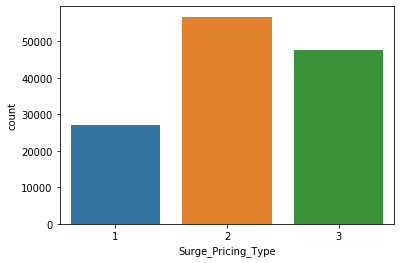

2    56728
3    47720
1    27214
Name: Surge_Pricing_Type, dtype: int64
Percentage ofSurge_Pricing_Type: 20.66959335267579 43.086084063738966 36.244322583585245


In [0]:
# Plot Distribution
sns.countplot(x='Surge_Pricing_Type',data=cab_data)
plt.show()

# What are the counts?
print(cab_data.Surge_Pricing_Type.value_counts())

# What is the percentage?
count_1 = len(cab_data[cab_data.Surge_Pricing_Type == 1])
count_2 = len(cab_data[cab_data.Surge_Pricing_Type == 2])
count_3 = len(cab_data[cab_data.Surge_Pricing_Type == 3])

percent_1 = (count_1/(count_1 + count_2 + count_3))*100
percent_2 = (count_2/(count_1 + count_2 + count_3))*100
percent_3 = (count_3/(count_1 + count_2 + count_3))*100

print('Percentage ofSurge_Pricing_Type:', percent_1, percent_2, percent_3 )

### _Drawing trends toward the target variable_

In [0]:
cab_data.groupby('Surge_Pricing_Type').mean()

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3
Surge_Pricing_Type,,,,,,,,
1,41.061633,5.898262,2.847554,3.112791,0.516242,66.033552,51.316785,76.252223
2,41.269265,5.957647,2.789416,2.857688,0.708627,64.343560,51.064078,74.772299
3,49.476234,6.154813,2.791163,2.689500,1.023093,63.347217,51.302703,74.829757


#### _Type Casting_

In [0]:
for col in cat_cols:
    cab_data[col] = cab_data[col].astype('category')

In [0]:
cab_data.dtypes

Trip_Distance                   float64
Type_of_Cab                    category
Customer_Since_Months           float64
Life_Style_Index                float64
Confidence_Life_Style_Index    category
Destination_Type               category
Customer_Rating                 float64
Cancellation_Last_1Month          int64
Var1                            float64
Var2                              int64
Var3                              int64
Gender                         category
Surge_Pricing_Type             category
dtype: object

In [0]:
cat_cols2 = ['Confidence_Life_Style_Index', 'Destination_Type', 'Gender', 'Type_of_Cab']
for col in cat_cols2:
    valid_data[col] = valid_data[col].astype('category')

In [0]:
valid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87395 entries, 0 to 87394
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   Trip_Distance                87395 non-null  float64 
 1   Type_of_Cab                  74237 non-null  category
 2   Customer_Since_Months        83429 non-null  float64 
 3   Life_Style_Index             74068 non-null  float64 
 4   Confidence_Life_Style_Index  74068 non-null  category
 5   Destination_Type             87395 non-null  category
 6   Customer_Rating              87395 non-null  float64 
 7   Cancellation_Last_1Month     87395 non-null  int64   
 8   Var1                         40606 non-null  float64 
 9   Var2                         87395 non-null  int64   
 10  Var3                         87395 non-null  int64   
 11  Gender                       87395 non-null  category
dtypes: category(4), float64(5), int64(3)
memory usage: 5.7 MB


#### Split Numeric and Categorical Columns

## Sklearn pipelines

Pipelines are a way to streamline a lot of the routine processes, encapsulating little pieces of logic into one function call, which makes it easier to actually do modeling instead just writing a bunch of code.

Pipelines are set up with the fit/transform/predict functionality, so you can fit a whole pipeline to the training data and transform to the test data, without having to do it individually for each thing you do. Super convenienent, right??

In single sentence a Pipeline is a Pipeline of transforms with a final estimator.

Steps to follow to create a pipeline

Step 1) Fetch the numerical and categorical columns

Step 2) Create a transformer/pipeline for numerical attributes

    Create a list of tuples where each tuple represents the operation to be performed on numerical attributes

Step 3) Create a transformer/pipeline for categorical attributes

    Create a list of tuples where each tuple represent the operation to be performed on categorical attributes

Step 4) Create a ColumnTransformer which merges both the numerical and categorical transformers

Step5) Create a final pipeline object which includes the ColumnTransformer and an estimator (an algorithm to be build on dataset)

Step6) (optional) Create a GridSearchCV object with pipeline as one of the inputs along with hyperparameter grid and Cross validation object

Step7) Apply fit() on train data and predict() on test data <br><br>

__Bird's view of sklearn pipeline__

<img src="Pipeline_broadview.png"><br><br>

__Train and Test dataflow inside the sklearn pipeline__
<img src="fit_tranform.jpg">

#### _Instantiate Pre-processing Objects for Pipeline_

In [0]:
from sklearn.impute import SimpleImputer 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [0]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols2)])

### _Train-Test Split_

In [0]:
X_train, X_test, y_train, y_test = train_test_split(cab_data.drop(['Surge_Pricing_Type'],axis=1),
                                                 cab_data['Surge_Pricing_Type'],test_size = 0.2,random_state=1)

In [0]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
y_test.shape 

(105329, 12)
(26333, 12)
(105329,)


(26333,)

In [0]:
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

#### _Instantiate Pipeline Object_

### _Build Decision Tree Model - 2_

In [0]:
clf_dt = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier())])

dt_param_grid = {'classifier__criterion': ['entropy', 'gini'], 'classifier__max_depth': [6,8,10,12], 
                 "classifier__min_samples_split": [2, 10, 20],"classifier__min_samples_leaf": [1, 5, 10]}

dt_grid = GridSearchCV(clf_dt, param_grid=dt_param_grid, cv=5)

dt_grid.fit(X_train,y_train)

In [0]:
dt_grid.best_params_

#{'classifier__criterion': 'gini',
 #'classifier__max_depth': 6,
 #'classifier__min_samples_leaf': 1,
 #'classifier__min_samples_split': 2}

{'classifier__criterion': 'gini',
 'classifier__max_depth': 6,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2}

In [0]:
train_pred = dt_grid.predict(X_train)
test_pred = dt_grid.predict(X_test)

print(dt_grid.score(X_train, y_train))
print(dt_grid.score(X_test, y_test))

print(confusion_matrix(y_true=y_train, y_pred = train_pred))

confusion_matrix_test = confusion_matrix(y_true=y_test, y_pred =  test_pred)


0.8411405295315683
0.7967479674796748
[[ 78  75]
 [  3 335]]


In [0]:
Accuracy_test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])

Precision_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,1]+confusion_matrix_test[0,1])
Recall_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0]+confusion_matrix_test[1,1])

print("Test Precision: ",Precision_Test)
print("Test Recall: ",Recall_Test)
print("Test Accuracy: ",Accuracy_test)

Test Precision:  0.7864077669902912
Test Recall:  0.9642857142857143
Test Accuracy:  0.7967479674796748


In [0]:
valid_pred_dt = dt_grid.predict(valid_data)

In [0]:
valid_pred_dt

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

In [0]:
valid_pred_dt = pd.DataFrame(valid_pred_dt)
valid_pred_dt

In [0]:
valid_pred_dt.to_csv('valid_pred_dt.csv')

### _Build Random Forest Model - 3_ (Using Stratified KFold)

__Stratified K-Folds cross-validator__

This cross-validation object is a **variation** of KFold that returns stratified folds. The folds are made by **preserving the percentage of samples for each class**.

In [0]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

In [0]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=143)

param_grid = {'classifier__criterion': ['entropy', 'gini'], 'classifier__max_depth': [6,8,10,12], 
                 "classifier__min_samples_split": [2, 10, 20],"classifier__min_samples_leaf": [1, 5, 10],
                   "classifier__n_estimators" : [150, 250, 300],
              "classifier__max_depth" : [5,8,10],
              "classifier__max_features" : [3, 5, 7],
              "classifier__min_samples_leaf" : [4, 6, 8, 10]}

rf_grid = RandomizedSearchCV(clf, param_distributions = param_grid, n_iter = 100, cv=kfold, verbose=2, random_state=42, n_jobs = 1)

In [0]:
rf_grid.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] classifier__n_estimators=300, classifier__min_samples_split=10, classifier__min_samples_leaf=8, classifier__max_features=7, classifier__max_depth=10, classifier__criterion=gini 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  classifier__n_estimators=300, classifier__min_samples_split=10, classifier__min_samples_leaf=8, classifier__max_features=7, classifier__max_depth=10, classifier__criterion=gini, total=  35.0s
[CV] classifier__n_estimators=300, classifier__min_samples_split=10, classifier__min_samples_leaf=8, classifier__max_features=7, classifier__max_depth=10, classifier__criterion=gini 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.0s remaining:    0.0s


[CV]  classifier__n_estimators=300, classifier__min_samples_split=10, classifier__min_samples_leaf=8, classifier__max_features=7, classifier__max_depth=10, classifier__criterion=gini, total=  35.2s
[CV] classifier__n_estimators=300, classifier__min_samples_split=10, classifier__min_samples_leaf=8, classifier__max_features=7, classifier__max_depth=10, classifier__criterion=gini 
[CV]  classifier__n_estimators=300, classifier__min_samples_split=10, classifier__min_samples_leaf=8, classifier__max_features=7, classifier__max_depth=10, classifier__criterion=gini, total=  35.1s
[CV] classifier__n_estimators=300, classifier__min_samples_split=10, classifier__min_samples_leaf=8, classifier__max_features=7, classifier__max_depth=10, classifier__criterion=gini 
[CV]  classifier__n_estimators=300, classifier__min_samples_split=10, classifier__min_samples_leaf=8, classifier__max_features=7, classifier__max_depth=10, classifier__criterion=gini, total=  33.5s
[CV] classifier__n_estimators=300, class

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 164.8min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=143, shuffle=True),
                   error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=False,
        

In [0]:
rf_grid.best_params_
#{'classifier__criterion': 'gini',
 #'classifier__max_depth': 10,
 #'classifier__max_features': 7,
#'classifier__min_samples_leaf': 8,
# 'classifier__min_samples_split': 10,
 #'classifier__n_estimators': 300}

{'classifier__criterion': 'gini',
 'classifier__max_depth': 10,
 'classifier__max_features': 7,
 'classifier__min_samples_leaf': 8,
 'classifier__min_samples_split': 10,
 'classifier__n_estimators': 300}

In [0]:
train_pred = rf_grid.predict(X_train)
test_pred = rf_grid.predict(X_test)

print(rf_grid.score(X_train, y_train))
print(rf_grid.score(X_test, y_test))

print(confusion_matrix(y_true=y_train, y_pred = train_pred))

confusion_matrix_test = confusion_matrix(y_true=y_test, y_pred =  test_pred)


Accuracy_test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])

Precision_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,1]+confusion_matrix_test[0,1])
Recall_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0]+confusion_matrix_test[1,1])

print("Test Precision: ",Precision_Test)
print("Test Recall: ",Recall_Test)
print("Test Accuracy: ",Accuracy_test)

0.6908923468370535
0.6845403106368435
[[11755  8181  1791]
 [ 1684 39574  4118]
 [ 2216 14568 21442]]
Test Precision:  0.82626481883453
Test Recall:  0.9617141191332232
Test Accuracy:  0.8380447585394581


In [0]:
valid_pred_rf = rf_grid.predict(valid_data)

In [0]:
valid_pred_rf

array([1, 2, 2, ..., 1, 2, 2])

In [0]:
valid_pred_rf = pd.DataFrame(valid_pred_rf)
valid_pred_rf

,0
0,1
1,2
2,2
3,2
4,2
...,...
87390,2
87391,2
87392,1
87393,2


In [0]:
valid_pred_rf.to_csv('valid_pred_rf.csv')

### _Build Gradient Boosting - 4_

In [0]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('GBM',GradientBoostingClassifier())])

In [0]:
gbm_param_grid = {'GBM__max_depth': [8,10,12,14], 'GBM__subsample': [0.8, 0.6,], 'GBM__max_features':[0.2, 0.3], 
              'GBM__n_estimators': [10, 20, 30]}

gbm_grid = GridSearchCV(clf, param_grid=gbm_param_grid, cv=3)

gbm_grid.fit(X_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                    

In [0]:
gbm_grid.best_params_
#{'GBM__max_depth': 10,
 #'GBM__max_features': 0.3,
 #'GBM__n_estimators': 30,
 #'GBM__subsample': 0.8}

{'GBM__max_depth': 10,
 'GBM__max_features': 0.3,
 'GBM__n_estimators': 30,
 'GBM__subsample': 0.8}

In [0]:
train_pred = gbm_grid.predict(X_train)
test_pred = gbm_grid.predict(X_test)

print(gbm_grid.score(X_train, y_train))
print(gbm_grid.score(X_test, y_test))

print(confusion_matrix(y_true=y_train, y_pred = train_pred))

confusion_matrix_test = confusion_matrix(y_true=y_test, y_pred =  test_pred)


Accuracy_test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])

Precision_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,1]+confusion_matrix_test[0,1])
Recall_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0]+confusion_matrix_test[1,1])

print("Test Precision: ",Precision_Test)
print("Test Recall: ",Recall_Test)
print("Train Accuracy: ",Accuracy_test)

0.7319636567327137
0.6908821630653552
[[12324  7795  1608]
 [ 1457 39585  4334]
 [ 1375 11663 25188]]
Test Precision:  0.8223672908434977
Test Recall:  0.9611484790683666
Train Accuracy:  0.8353674892703863


In [0]:
valid_pred_gbm = gbm_grid.predict(valid_data)
valid_pred_gbm = pd.DataFrame(valid_pred_gbm)
valid_pred_gbm.to_csv('valid_pred_gbm.csv')
valid_pred_gbm 

In [0]:
### KNN 

In [0]:
from sklearn.neighbors import KNeighborsClassifier
clf_knn = Pipeline(steps=[('preprocessor', preprocessor),
                      ('KNN',KNeighborsClassifier())])

In [0]:
knn_param_grid = {'KNN__n_neighbors':[23,25,30,40],
    'KNN__weights':['uniform','distance'],
    'KNN__metric':['euclidean','manhattan','minkowski']}

knn_grid = GridSearchCV(clf, param_grid = knn_param_grid, cv=3)

knn_grid.fit(X_train,y_train)

TypeError: ignored

In [0]:
.best_params_

## _Handling Imbalanced Data_

### _1. Class Weights of loss function_

In [0]:
clf_dt = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier())])

dt_param_grid = {'classifier__criterion': ['entropy', 'gini'], 'classifier__max_depth': [6,8,10,12], 
                 "classifier__min_samples_split": [2, 10, 20],"classifier__min_samples_leaf": [1, 5, 10],
                 "classifier__class_weight":['balanced']}

dt_grid_bal = GridSearchCV(clf_dt, param_grid=dt_param_grid, cv=5)
dt_grid_bal.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                    

In [0]:
dt_grid_bal.best_params_
#{'classifier__class_weight': 'balanced',
 #'classifier__criterion': 'gini',
 #'classifier__max_depth': 6,
 #'classifier__min_samples_leaf': 10,
 #'classifier__min_samples_split': 2}

{'classifier__class_weight': 'balanced',
 'classifier__criterion': 'gini',
 'classifier__max_depth': 6,
 'classifier__min_samples_leaf': 10,
 'classifier__min_samples_split': 2}

In [0]:
train_pred = dt_grid_bal.predict(X_train)
test_pred = dt_grid_bal.predict(X_test)

print(dt_grid_bal.score(X_train, y_train))
print(dt_grid_bal.score(X_test, y_test))

print(confusion_matrix(y_true=y_train, y_pred = train_pred))

confusion_matrix_test = confusion_matrix(y_true=y_test, y_pred =  test_pred)


Accuracy_test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])

Precision_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,1]+confusion_matrix_test[0,1])
Recall_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0]+confusion_matrix_test[1,1])

print("Test Precision: ",Precision_Test)
print("Test Recall: ",Recall_Test)
print("Train Accuracy: ",Accuracy_test)

0.6677078487406127
0.6693122697755668
[[13011  7023  1693]
 [ 4043 36551  4782]
 [ 3520 13939 20767]]
Test Precision:  0.8383783292427961
Test Recall:  0.904481710306953
Train Accuracy:  0.8193633081719724


In [0]:
valid_pred_dt_bal = dt_grid_bal.predict(valid_data)

In [0]:
valid_pred_dt_bal = pd.DataFrame(valid_pred_dt_bal)
valid_pred_dt_bal

,0
0,1
1,1
2,2
3,2
4,2
...,...
87390,2
87391,2
87392,1
87393,2


In [0]:
valid_pred_dt_bal.to_csv('valid_pred_dt_bal.csv')

### _2. Oversample Using SMOTE_

<img src="SMOTE.jpg" width = '400'><br>

In [0]:
clf = Pipeline(steps=[('preprocessor', preprocessor)])

X_train_pp = pd.DataFrame(clf.fit_transform(X_train))
X_test_pp = pd.DataFrame(clf.transform(X_test))

In [0]:
X_train_pp.shape

(105329, 32)

In [0]:
###### from imblearn.over_sampling import SMOTE

smote = SMOTE('minority', random_state=0)


os_data_X,os_data_y=smote.fit_sample(X_train_pp, y_train)

os_data_X = pd.DataFrame(data=os_data_X)
os_data_y= pd.DataFrame(data=os_data_y,columns=['Surge_Pricing_Type'])
print(os_data_X.shape)
os_data_y.shape

# we can Check the numbers of our data
#print("length of oversampled data is ",len(os_data_X))
#print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['Surge_Pricing_Type']=='1']))
#print("Number of subscription",len(os_data_y[os_data_y['y']=='2']))
#print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']=='1'])/len(os_data_X))
#print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']=='2'])/len(os_data_X))

(128978, 32)


(128978, 1)

In [0]:
clf_gbm_smote = Pipeline(steps=[('GBM_smote', GradientBoostingClassifier())])

gbm_smote_param_grid = {'GBM_smote__max_depth': [8,10,12,14], 'GBM_smote__subsample': [0.8, 0.6,], 
                  'GBM_smote__max_features':[0.2, 0.3], 
              'GBM_smote__n_estimators': [10, 20, 30]}

gbm_smote_grid = GridSearchCV(clf_gbm_smote, param_grid=gbm_smote_param_grid, cv = 5, verbose=2, n_jobs = 1)

gbm_smote_grid.fit(os_data_X,os_data_y)
#dt_param_grid = {'classifier__criterion': ['entropy', 'gini'], 'classifier__max_depth': [6,8,10,12], 
                 #"classifier__min_samples_split": [2, 10, 20],"classifier__min_samples_leaf": [1, 5, 10]}

#dt_grid_bal = GridSearchCV(clf_dt, param_grid=dt_param_grid, cv=5)

#dt_grid_bal.fit(os_data_X,os_data_y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] GBM_smote__max_depth=8, GBM_smote__max_features=0.2, GBM_smote__n_estimators=10, GBM_smote__subsample=0.8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  GBM_smote__max_depth=8, GBM_smote__max_features=0.2, GBM_smote__n_estimators=10, GBM_smote__subsample=0.8, total=   5.9s
[CV] GBM_smote__max_depth=8, GBM_smote__max_features=0.2, GBM_smote__n_estimators=10, GBM_smote__subsample=0.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s


[CV]  GBM_smote__max_depth=8, GBM_smote__max_features=0.2, GBM_smote__n_estimators=10, GBM_smote__subsample=0.8, total=   5.8s
[CV] GBM_smote__max_depth=8, GBM_smote__max_features=0.2, GBM_smote__n_estimators=10, GBM_smote__subsample=0.8 
[CV]  GBM_smote__max_depth=8, GBM_smote__max_features=0.2, GBM_smote__n_estimators=10, GBM_smote__subsample=0.8, total=   5.7s
[CV] GBM_smote__max_depth=8, GBM_smote__max_features=0.2, GBM_smote__n_estimators=10, GBM_smote__subsample=0.8 
[CV]  GBM_smote__max_depth=8, GBM_smote__max_features=0.2, GBM_smote__n_estimators=10, GBM_smote__subsample=0.8, total=   5.6s
[CV] GBM_smote__max_depth=8, GBM_smote__max_features=0.2, GBM_smote__n_estimators=10, GBM_smote__subsample=0.8 
[CV]  GBM_smote__max_depth=8, GBM_smote__max_features=0.2, GBM_smote__n_estimators=10, GBM_smote__subsample=0.8, total=   5.6s
[CV] GBM_smote__max_depth=8, GBM_smote__max_features=0.2, GBM_smote__n_estimators=10, GBM_smote__subsample=0.6 
[CV]  GBM_smote__max_depth=8, GBM_smote__max

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 91.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('GBM_smote',
                                        GradientBoostingClassifier(ccp_alpha=0.0,
                                                                   criterion='friedman_mse',
                                                                   init=None,
                                                                   learning_rate=0.1,
                                                                   loss='deviance',
                                                                   max_depth=3,
                                                                   max_features=None,
                                                                   max_leaf_nodes=None,
                                                                   min_impurity_decrease=0.0,
                                                                   min_impurity_split=None,
   

In [0]:
gbm_smote_grid.best_params_

#{'GBM_smote__max_depth': 14,
 #'GBM_smote__max_features': 0.3,
 #'GBM_smote__n_estimators': 30,
 #'GBM_smote__subsample': 0.8}

{'GBM_smote__max_depth': 14,
 'GBM_smote__max_features': 0.3,
 'GBM_smote__n_estimators': 30,
 'GBM_smote__subsample': 0.8}

In [0]:
train_pred = gbm_smote_grid.predict(os_data_X)
test_pred = gbm_smote_grid.predict(X_test_pp)

print(gbm_smote_grid.score(os_data_X, os_data_y))
print(gbm_smote_grid.score(X_test_pp, y_test))

print(confusion_matrix(y_true=os_data_y, y_pred = train_pred))

confusion_matrix_test = confusion_matrix(y_true=y_test, y_pred =  test_pred)


Accuracy_test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])

Precision_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,1]+confusion_matrix_test[0,1])
Recall_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0]+confusion_matrix_test[1,1])

print("Test Precision: ",Precision_Test)
print("Test Recall: ",Recall_Test)
print("Train Accuracy: ",Accuracy_test)

0.8567662702166261
0.6835909315307789
[[38578  6026   772]
 [ 1590 41645  2141]
 [ 1055  6890 30281]]
Test Precision:  0.8290528971794179
Test Recall:  0.9319286871961102
Train Accuracy:  0.827236045729657


In [0]:
valid_data_pp = pd.DataFrame(clf.fit_transform(valid_data))


In [0]:
valid_pred_gbm_smote_grid = gbm_smote_grid.predict(valid_data_pp)
valid_pred_gbm_smote_grid = pd.DataFrame(valid_pred_gbm_smote_grid)
valid_pred_gbm_smote_grid.to_csv('valid_pred_gbm_smote_grid.csv')
valid_pred_gbm_smote_grid

,0
0,1
1,1
2,2
3,2
4,2
...,...
87390,2
87391,2
87392,1
87393,2


## _Insights_

* Excel Sheet Analysis


* Positive : Yes to Campaign ; Negative : No to Campaign


* Recall Importance : False pos

### Bayesian Optimization for Random Forest Model 

In [0]:
# Install hyperopt
# ! pip install hyperopt

#### Building a Random forest model using bayesian optimization.

In [0]:
### handling outliers

In [0]:
def outliers(data,num_cols):
    #num_cols = data.select_dtypes(exclude='category')
    #cat_cols = data.select_dtypes(include='category')
    for col in num_cols:
        mu = data[col].mean()
        sigma = data[col].std()
        min_val = mu - 3*sigma
        max_val = mu + 3*sigma
        data.drop(data.loc[(data[col] > max_val) | (data[col] < min_val),].index,inplace=True)
    return data
train = outliers(train, num_cols)


In [0]:
def getUpperLowerQuantiles(data) :
    LowerQuantile=[]
    UpperQuantile=[]
    num_cols=data.select_dtypes(include=['int64','float64']).columns
    print(num_cols)
    for i in num_cols:
        LowerQuantile.append(data[i].quantile(.01))
        UpperQuantile.append(data[i].quantile(.99))
    return(LowerQuantile,UpperQuantile)

In [0]:
LowerQuantile,UpperQuantile=list(getUpperLowerQuantiles(cab_data))

Index(['Trip_Distance', 'Customer_Since_Months', 'Life_Style_Index',
       'Customer_Rating', 'Cancellation_Last_1Month', 'Var1', 'Var2', 'Var3',
       'Surge_Pricing_Type'],
      dtype='object')


In [0]:
LowerQuantile

[5.216100000000001,
 0.0,
 2.2723372,
 0.6695125000000002,
 0.0,
 31.0,
 43.0,
 56.0,
 1.0]

In [0]:
UpperQuantile

[108.35, 10.0, 3.3810219999999993, 4.79125, 4.0, 110.0, 67.0, 109.0, 3.0]

In [0]:
def getOutliers(data) :
    for i in range(data.shape[1]):
        print("--------------")
        print(data.iloc[:,i][data.iloc[:,i]>UpperQuantile[i]])
        print(data.iloc[:,i][data.iloc[:,i]<LowerQuantile[i]])

In [0]:
getOutliers(cab_data[num_cols]) 


--------------
54        108.50
128       108.74
151       108.63
183       108.93
282       108.94
           ...  
130861    108.79
131090    108.50
131225    108.39
131456    108.95
131543    109.03
Name: Trip_Distance, Length: 1314, dtype: float64
36        4.78
48        2.83
114       4.29
133       4.27
164       3.47
          ... 
131372    2.28
131411    3.80
131431    4.78
131517    2.38
131627    4.35
Name: Trip_Distance, Length: 1317, dtype: float64
--------------
Series([], Name: Customer_Since_Months, dtype: float64)
Series([], Name: Customer_Since_Months, dtype: float64)
--------------
183       3.53792
282       3.47270
526       3.53650
605       3.43832
607       3.39795
           ...   
131387    3.39832
131442    3.51799
131539    3.50566
131543    3.62424
131581    3.44766
Name: Life_Style_Index, Length: 1115, dtype: float64
15        2.16167
495       2.16962
542       2.25945
837       2.13555
926       2.04254
           ...   
131238    2.24949
131290    1.95

In [0]:
def clip_outliers(data):
    data.clip(lower=LowerQuantile, axis=1, inplace=True)
    data.clip(upper=UpperQuantile, axis=1, inplace=True)

In [0]:
clip_outliers(y_train)
clip_outliers(y_train_drop)

In [0]:
getOutliers(y_train)

In [0]:
clip_outliers(y_valid)
clip_outliers(y_valid_drop)

In [0]:
getOutliers(y_valid)

In [0]:
y_valid

In [0]:
### HyperOpt Parameter Tuning
from hyperopt import tpe
from hyperopt import STATUS_OK
from hyperopt import Trials
from hyperopt import hp
from hyperopt import fmin
from functools import partial

N_FOLDS = 10
MAX_EVALS = 50

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer

def gini(truth, predictions):
    print('truth is {}  and predictions is {}',truth)
    g = np.asarray(np.c_[truth, predictions, np.arange(len(truth)) ], dtype=np.float)
    print('Computed values is {}  ',g)
    print('g of 2 is ', g[:,2])
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(truth) + 1) / 2.
    return gs / len(truth)

def gini_sklearn(truth, predictions):
    return gini(truth, predictions) / gini(truth, truth)

gini_scorer = make_scorer(gini_sklearn, greater_is_better=True, needs_proba=True)

def objective_randomForest(params):
    params = {'n_estimators': int(params['n_estimators']), 'max_depth': int(params['max_depth'])}
    clf_rf = RandomForestClassifier(n_jobs=4, class_weight='balanced', **params)
    score = cross_val_score(clf_rf, X_train, y_train, scoring=gini_scorer, cv=StratifiedKFold()).mean()
    print("Gini {:.3f} params {}".format(score, params))
    return score

space = {
    'n_estimators': hp.quniform('n_estimators', 25, 300, 25),
    'max_depth': hp.quniform('max_depth', 1, 12, 1)
}

best = fmin(fn=objective_randomForest,
            space=space,
            algo=tpe.suggest,
            max_evals = 200)

Gini nan params {'n_estimators': 250, 'max_depth': 7}
Gini nan params {'n_estimators': 50, 'max_depth': 9}
Gini nan params {'n_estimators': 175, 'max_depth': 7}
Gini nan params {'n_estimators': 200, 'max_depth': 3}
Gini nan params {'n_estimators': 300, 'max_depth': 11}
Gini nan params {'n_estimators': 50, 'max_depth': 8}
Gini nan params {'n_estimators': 275, 'max_depth': 6}
Gini nan params {'n_estimators': 25, 'max_depth': 8}
Gini nan params {'n_estimators': 125, 'max_depth': 9}
Gini nan params {'n_estimators': 150, 'max_depth': 5}
Gini nan params {'n_estimators': 125, 'max_depth': 9}
Gini nan params {'n_estimators': 25, 'max_depth': 8}
Gini nan params {'n_estimators': 150, 'max_depth': 11}
Gini nan params {'n_estimators': 50, 'max_depth': 8}
Gini nan params {'n_estimators': 25, 'max_depth': 2}
Gini nan params {'n_estimators': 25, 'max_depth': 3}
Gini nan params {'n_estimators': 275, 'max_depth': 5}
Gini nan params {'n_estimators': 200, 'max_depth': 4}
Gini nan params {'n_estimators': 

AssertionError: ignored

In [0]:
best

NameError: ignored

In [0]:
params = {'n_estimators': 25, 'max_depth': 12}
clf_bo_rf = RandomForestClassifier(**params)

In [0]:
clf_bo_rf.fit(X_train_aligned, y_train_plain)

In [0]:
train_pred = clf_bo_rf.predict(X_train_aligned)
test_pred = clf_bo_rf.predict(X_test_aligned)

print(clf_bo_rf.score(X_train_aligned, y_train_plain))
print(clf_bo_rf.score(X_test_aligned, y_test_plain))

print(confusion_matrix(y_true=y_train_plain, y_pred = train_pred))

confusion_matrix_test = confusion_matrix(y_true=y_test_plain, y_pred =  test_pred)

In [0]:

Accuracy_test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])

Precision_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,1]+confusion_matrix_test[0,1])
Recall_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0]+confusion_matrix_test[1,1])

print("Test Precision: ",Precision_Test)
print("Test Recall: ",Recall_Test)
print("Test Accuracy: ",Accuracy_test)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import scipy.integrate

predictions = [0.9, 0.3, 0.8, 0.75, 0.65, 0.6, 0.78, 0.7, 0.05, 0.4, 0.4, 0.05, 0.5, 0.1, 0.1]
actual = [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]



In [0]:
np.arange(len(actual))

In [0]:
predictions

In [0]:
actual

In [0]:
all = np.asarray(np.c_[actual, predictions, np.arange(len(actual))], dtype=np.float)
all

In [0]:
all  = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
all

In [0]:
all[:, 0].cumsum().sum()

In [0]:
totalLosses = all[:, 0].sum()
giniSum = all[:, 0].cumsum().sum() / totalLosses
print('--',giniSum)
giniSum -= (len(actual) + 1) / 2
print('---',giniSum)
giniSum

In [0]:
len(actual) + 1/ 2

In [0]:
def gini(actual, pred):
    assert (len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)


def gini_normalized(actual, pred):
    return gini(actual, pred) / gini(actual, actual)

In [0]:
gini_predictions = gini(actual, predictions)
gini_max = gini(actual, actual)
ngini= gini_normalized(actual, predictions)
print('Gini: %.3f, Max. Gini: %.3f, Normalized Gini: %.3f' % (gini_predictions, gini_max, ngini))

In [0]:
gini(actual, predictions)

In [0]:
gini(actual, actual)